# Include a for loop within functions

# Countsnps
    - input: query and reference fasta file
    - output: matrix (snp count)
# calcpdistance 
    - input: query and reference fasta file
    - output: matrix (pairwise distance)
# Assigngenotypes 
    - input: matrix (pairwise distance)
    - output: CSV file (user sample names, reference name, the corresponding pairwise distance)

# PlotFrequency
    - input: dataframe from assigngenotype func
    - output: Barplot
# PlotPrototypeDistances
    - input: distance matrix from allprototypeDistance func
    - output: a heatmap (prototype on x-axis and query on y-axis)
    - interpretation: dark red color shows more similarity
# PlotTree (To be finalised)

In [1]:

readFasta <- function(fastaFile) {
  # Read all lines from the FASTA file
  lines <- readLines(fastaFile)
  
  # Initialize lists to store sequences and their headers
  seqList <- list() # Empty list
  headerList <- c() # Empty vector
  
  # Temporary storage for the current sequence being read
  currentSeq <- NULL
  
  # Iterate through each line of the FASTA file
  for (line in lines) {
    if (startsWith(line, ">")) {
      # If currentSeq is not NULL, it means we've finished reading a sequence
      # Add it to seqList
      if (!is.null(currentSeq)) {
        seqList[[length(seqList) + 1]] <- paste(currentSeq, collapse = "")
      }
      # Reset currentSeq for the next sequence
      currentSeq <- c()
      # Add the header (without the ">" character) to headerList
      headerList <- c(headerList, substring(line, 2))
    } else {
      # If the line is not a header, it's part of the current sequence
      # Convert it to uppercase and add it to currentSeq
      currentSeq <- c(currentSeq, toupper(line))
    }
  }
  
  # After the loop, add the last sequence to seqList if it exists
  if (!is.null(currentSeq)) {
    seqList[[length(seqList) + 1]] <- paste(currentSeq, collapse = "")
  }
  
  # Return a list containing the sequences and their corresponding headers
  return(list(sequences = seqList, headers = headerList))
}
                   
    

In [2]:
# Count the SNPs
countSNPs <- function(pathToRef, pathToQuery) {
  # Read reference sequences and headers
  fastaRef <- readFasta(pathToRef)
  refs <- fastaRef$sequences
  refHeaders <- fastaRef$headers
  
  # Read query sequences and headers
  fastaQuery <- readFasta(pathToQuery)
  queries <- fastaQuery$sequences
  queryHeaders <- fastaQuery$headers
  
  # Initialize matrix to store SNP counts
  snpMatrix <- matrix(nrow = length(queries), ncol = length(refs))
  
  # Convert reference sequences to character vectors
  refSeqs <- lapply(refs, function(ref) unlist(strsplit(ref, split = "")))
  
  # Iterate over each query sequence
  for (q in seq_along(queries)) {
    query <- queries[[q]]
    queryHeader <- queryHeaders[[q]]
    
    # Convert query sequence to character vector
    queryChars <- unlist(strsplit(query, split = ""))
    
    # Iterate over each reference sequence
    for (i in seq_along(refSeqs)) {
      refChars <- refSeqs[[i]]
      
      # Ensure both sequences are of the same length for comparison
      if (length(refChars) == length(queryChars)) {
        # Count the differences (SNPs)
        snpMatrix[q, i] <- sum(refChars != queryChars)
      } else {
        snpMatrix[q, i] <- NA  # Mark as NA if sequences are of different lengths (I have a problem with this, how do we actually test this?(perform inhouse alignment))
      }
    }
  }
  
  # Set row and column names
  rownames(snpMatrix) <- queryHeaders
  colnames(snpMatrix) <- refHeaders
  
  # Return SNP counts matrix
  return(snpMatrix)
}

###### - This section of countSNPs needs further discussion with other members

`
if (length(refChars) == length(queryChars)) {
        # Count the differences (SNPs)
        snpMatrix[q, i] <- sum(refChars != queryChars)
      } else {
        snpMatrix[q, i] <- NA    
` 

#Mark as NA if sequences are of different lengths (I have a problem with this, how do we actually test this?(perform inhouse alignment))

In [3]:
calcPDistance <- function(pathToRef, pathToQuery) {
  # Read reference sequences and headers
  fastaRef <- readFasta(pathToRef)
  refs <- fastaRef$sequences
  refHeaders <- fastaRef$headers
  
  # Read query sequences and headers
  fastaQuery <- readFasta(pathToQuery)
  queries <- fastaQuery$sequences
  queryHeaders <- fastaQuery$headers
  
  # Initialize matrix to store p-distances
  pDistancesMatrix <- matrix(nrow = length(queries), ncol = length(refs))
  
  # Iterate over each query sequence
  for (q in seq_along(queries)) {
    query <- queries[[q]]
    queryHeader <- queryHeaders[[q]]
    
    # Count SNPs between the query and each reference sequence
    snpCounts <- countSNPs(pathToRef, pathToQuery)
    
    # Calculate p-distance for each reference sequence
    for (i in seq_along(refHeaders)) {
      ref <- refs[[i]]
        #print(ref) Debugging
      snpCount <- snpCounts[q, i]  # SNP count between query and reference
      
      # Calculate p-distance
      pDistancesMatrix[q, i] <- snpCount / nchar(ref)
    }
  }
  
  # Set row and column names
  rownames(pDistancesMatrix) <- queryHeaders
  colnames(pDistancesMatrix) <- refHeaders
  
  return(pDistancesMatrix)
}


In [4]:
# Count snps (query vs ref)
countSNPs('test_align.fasta','test_align_1_usernames.fasta')


,97816_A8,98103_B48,97412_C43,GQ323774.1_RVC10genome,95114_C10
sample43,156,182,0,101,90
sample10,164,173,101,0,28
sample10,157,190,90,28,0


In [5]:
calcPDistance('test_align.fasta','test_align_1_usernames.fasta')


,97816_A8,98103_B48,97412_C43,GQ323774.1_RVC10genome,95114_C10
sample43,0.3489933,0.4071588,0.0000000,0.22595078,0.20134228
sample10,0.3668904,0.3870246,0.2259508,0.00000000,0.06263982
sample10,0.3512304,0.4250559,0.2013423,0.06263982,0.00000000


# Models for calculating genetic distances

In [11]:
# Function to calculate Jukes-Cantor genetic distance
calcJukesCantorDistance <- function(pathToRef, pathToQuery) {
  # Calculate p-distance
  p_dist <- calcPDistance(pathToRef, pathToQuery)

  # Calculate Jukes-Cantor genetic distance
  jc_dist <- -3/4 * log(1 - 4/3 * p_dist)

  # Return the Jukes-Cantor genetic distance
  return(jc_dist)
}

# Example usage
#calcJukesCantorDistance(pathToRef = "./data/RVBPrototypeAligned.fasta", pathToQuery = "./data/tmp_query.fasta")


# Kimura 2 parameter (transitions vs transversions)

## Function to calculate proportions of transitions and transversions
calcTransitionTransversions <- function(refChars, queryChars) {
  transitions <- sum((refChars == 'A' & queryChars == 'G') |
                       (refChars == 'G' & queryChars == 'A') |
                       (refChars == 'C' & queryChars == 'T') |
                       (refChars == 'T' & queryChars == 'C'))

  transversions <- sum((refChars == 'A' & queryChars == 'C') |
                         (refChars == 'A' & queryChars == 'T') |
                         (refChars == 'G' & queryChars == 'C') |
                         (refChars == 'G' & queryChars == 'T') |
                         (refChars == 'C' & queryChars == 'A') |
                         (refChars == 'C' & queryChars == 'G') |
                         (refChars == 'T' & queryChars == 'A') |
                         (refChars == 'T' & queryChars == 'G'))

  total_sites <- length(refChars)
  P <- transitions / total_sites
  Q <- transversions / total_sites

  return(list(P = P, Q = Q))
}

## Function to calculate Kimura 2-parameter genetic distance
calcKimura2pDistance <- function(pathToRef, pathToQuery) {
  # Read multiple reference sequences and one query sequence
  refsData <- readFasta(pathToRef)
  refs <- refsData$sequences
  refHeaders <- refsData$headers

  queryData <- readFasta(pathToQuery)
  query <- queryData$sequences[[1]]  # Assuming only one query sequence
  queryHeader <- queryData$headers[[1]]  # Assuming only one query header

  # Initialize a matrix to store the distances
  k2pMatrix <- matrix(nrow = 1, ncol = length(refs),
                      dimnames = list(c(queryHeader), refHeaders))

  # Convert the query sequence to character vector
  queryChars <- strsplit(query, split = "")[[1]]

  # Iterate over each reference sequence
  for (i in seq_along(refs)) {
    refChars <- strsplit(refs[[i]], split = "")[[1]]

    # Calculate proportions of transitions and transversions
    tt <- calcTransitionTransversions(refChars, queryChars)
    P <- tt$P
    Q <- tt$Q

    # Calculate Kimura 2-parameter genetic distance
    K2P_distance <- -0.5 * log((1 - 2*P - Q) * sqrt(1 - 2*Q))

    # Store the distance
    k2pMatrix[1, i] <- K2P_distance
  }

  # Return the matrix of Kimura 2-parameter genetic distances
  return(k2pMatrix)
}


# Example usage
#calcKimura2pDistance(pathToRef = "./data/RVBPrototypeAligned.fasta", pathToQuery = "./data/tmp_query.fasta")


# calculate Tamura 3-parameter genetic distance
calcTamura3pDistance <- function(pathToRef, pathToQuery) {
  # Read multiple reference sequences and one query sequence
  refsData <- readFasta(pathToRef)
  refs <- refsData$sequences
  refHeaders <- refsData$headers

  queryData <- readFasta(pathToQuery)
  query <- queryData$sequences[[1]]  # Assuming only one query sequence
  queryHeader <- queryData$headers[[1]]  # Assuming only one query header

  # Initialize a matrix to store the distances
  tamuraMatrix <- matrix(nrow = 1, ncol = length(refs),
                         dimnames = list(c(queryHeader), refHeaders))

  # Convert the query sequence to character vector
  queryChars <- strsplit(query, split = "")[[1]]

  # Iterate over each reference sequence
  for (i in seq_along(refs)) {
    refChars <- strsplit(refs[[i]], split = "")[[1]]

    # Calculate base frequencies for both sequences
    gcContentRef <- sum(refChars %in% c("G", "C")) / length(refChars)
    gcContentQuery <- sum(queryChars %in% c("G", "C")) / length(queryChars)

    # Calculate transitions and transversions
    tt_results <- calcTransitionTransversions(refChars, queryChars)
    P <- tt_results$P
    Q <- tt_results$Q

    theta1 <- gcContentRef
    theta2 <- gcContentQuery
    C <- theta1 + theta2 - 2 * theta1 * theta2

    # Tamura distance calculation
    if ((1 - P/C - Q) > 0 && (1 - 2*Q) > 0) {
      distance <- -C * log(1 - P/C - Q) - 0.5 * (1 - C) * log(1 - 2*Q)
    } else {
      distance <- NA  # Distance cannot be calculated under these conditions
    }

    # Store the distance
    tamuraMatrix[1, i] <- distance
  }

  # Return the matrix of Tamura 3-parameter genetic distances
  return(tamuraMatrix)
}

In [12]:
allPrototypeDistances <- function(pathToRef, pathToQuery, model = "p-distance") {
  # Determine which model to use based on user input
  if (model == "p-distance") {
    result <- calcPDistance(pathToRef, pathToQuery)
  } else if (model == "JC") {
    result <- calcJukesCantorDistance(pathToRef, pathToQuery)
  } else if (model == "Kimura2p") {
    result <- calcKimura2pDistance(pathToRef, pathToQuery)
  } else if (model == "Tamura3p") {
    result <- calcTamura3pDistance(pathToRef, pathToQuery)
  } else {
    stop("Unknown model specified. Choose from 'p-distance', 'JC', 'Kimura2p', or 'Tamura3p'.")
  }

  # Return the result of the chosen model
  return(result)
}

In [13]:
calcJukesCantorDistance('test_align.fasta','test_align_1_usernames.fasta')

,97816_A8,98103_B48,97412_C43,GQ323774.1_RVC10genome,95114_C10
sample43,0.4695713,0.5871045,0.0000000,0.26886570,0.23444882
sample10,0.5038140,0.5443036,0.2688657,0.00000000,0.06541108
sample10,0.4737671,0.6273151,0.2344488,0.06541108,0.00000000


In [83]:
dist=allPrototypeDistances('test_align.fasta','test_align_1_usernames.fasta',model='JC')

In [32]:
data_type <- assignTypes('test_align.fasta','test_align_1_usernames.fasta','p-distance',0.105)

In [49]:
data_type <- assignTypes('test_align.fasta','test_align_1_usernames.fasta','p-distance',0.105)

# PlotFrequency
To visualize the genotype assigned frequency in the sample under evaluation

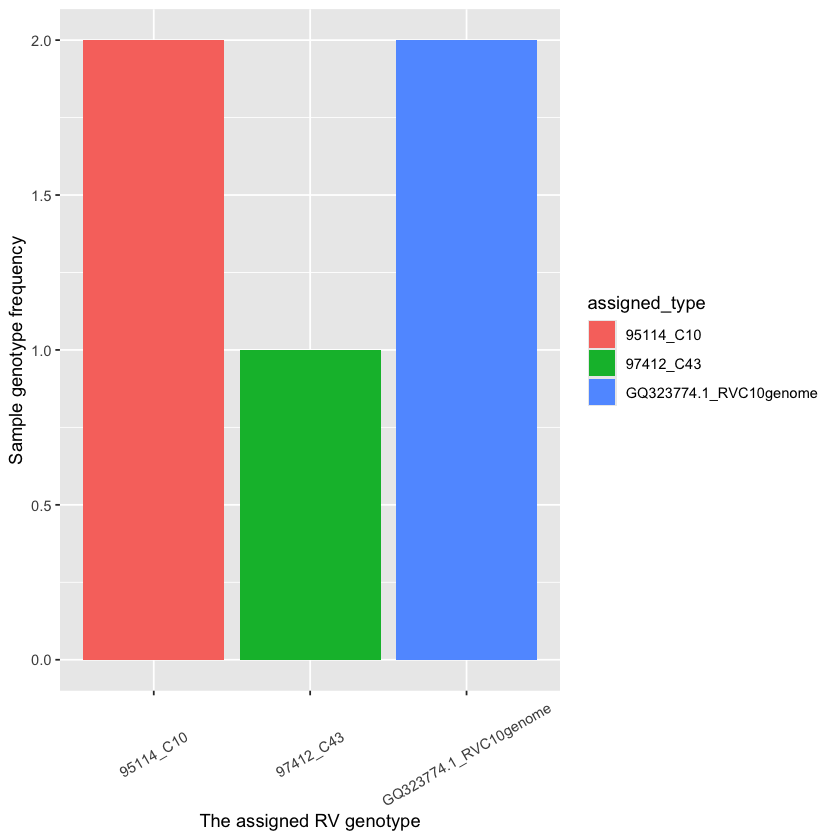

In [50]:
# data_type %>% 
# count(assigned_type) %>%
# ggplot(aes(x=assigned_type,y=n,fill=assigned_type))+
# geom_col()

#Convert this to a function
PlotFrequency <- function(genotypeassigned,xlab='The assigned RV genotype',ylab='Sample genotype frequency'){
    # This function takes assignTypes() output and the user-supplied x and y-axis labels.
    # It tabulates the frequency of unique entries of the assigned_type column
    # Visualize using a bar plot the frequency of each genotype present in user samples
    plot=genotypeassigned %>%
    count(assigned_type) %>%
    ggplot(aes(x=assigned_type,y=n,fill=assigned_type))+
    geom_col()+
    labs(x=xlab, y=ylab)+
    theme(axis.text.x = element_text(angle = 30, hjust = 0.5, vjust = 0.5))
    return(plot)
}

PlotFrequency(data_type)


In [17]:
assignTypes('test_align.fasta','test_align_1_usernames.fasta','p-distance',0.105)

query,assigned_type,distance
<chr>,<chr>,<dbl>
sample43,97412_C43,0.00000000
sample10,GQ323774.1_RVC10genome,0.00000000
sample10,95114_C10,0.06263982
sample10,GQ323774.1_RVC10genome,0.06263982
sample10,95114_C10,0.00000000


In [21]:
overallMeanDistance('test_align.fasta')

[1] 0.3232662

In [140]:
dist

,97816_A8,98103_B48,97412_C43,GQ323774.1_RVC10genome,95114_C10
sample43,0.4695713,0.5871045,0.0000000,0.26886570,0.23444882
sample10,0.5038140,0.5443036,0.2688657,0.00000000,0.06541108
sample10,0.4737671,0.6273151,0.2344488,0.06541108,0.00000000


# PlotPrototypeDistances
Use a heatmap to visualize the distances between the prototypes and the user supplied query sequences

In [163]:
library(gplots)
PlotPrototypeDistances <- function(pairwisedist, title="Dissimilarity Matrix Heatmap",xlabel='Prototype Refs',
                                  ylabel='Query sequences'){
    # This function takes a matrix of pairwise distance from allprotypeDistances func
    # Use gplot:heatmap.2, dark red shows more similarity
    # Modify the column names
    colnames(pairwisedist) <- sub(".*?_", "", colnames(pairwisedist)) # Comment out if you want to keep ref seq names as they are 
    heatmap <- heatmap.2(pairwisedist,
                         Rowv = NULL, Colv = NULL,  
                         dendrogram = 'none',       
                         trace = 'none',            
                         col = heat.colors(256),   
                         scale = 'row',             
                         margins = c(5, 10),        
                         main = title,
                        ylab=ylabel,
                        xlab=xlabel,
                        cex.axis = 0.8,
                        cex.lab = 0.8,
                        srtCol = 45,
                        adjCol = c(0, 0))   # Turn off this code to adjust the position
             
    return(heatmap$call) # Return the plot
}

heatmap.2(x = pairwisedist, Rowv = NULL, Colv = NULL, dendrogram = "none", 
    scale = "row", col = heat.colors(256), trace = "none", margins = c(5, 
        10), srtCol = 45, adjCol = c(0, 0), main = title, xlab = xlabel, 
    ylab = ylabel, cex.axis = 0.8, cex.lab = 0.8)

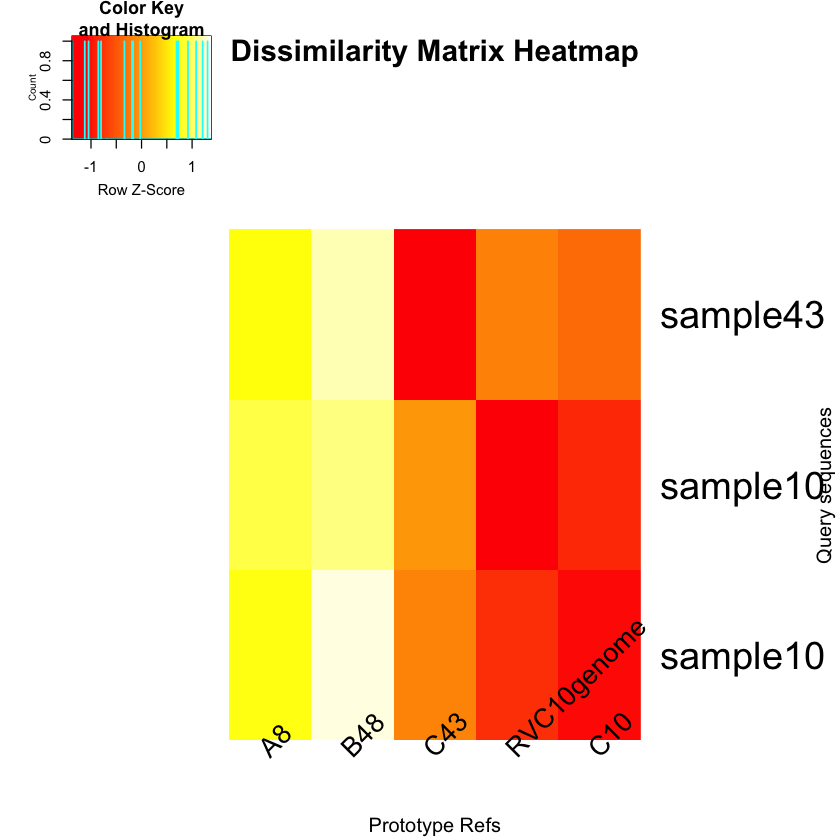

In [164]:
PlotPrototypeDistances(dist)

# Plottree

This code is in baby steps.


In [171]:
modified_matrix=t(dist) # Transform the matrix
modified_matrix

,sample43,sample10,sample10
97816_A8,0.4695713,0.50381403,0.47376710
98103_B48,0.5871045,0.54430362,0.62731509
97412_C43,0.0000000,0.26886570,0.23444882
GQ323774.1_RVC10genome,0.2688657,0.00000000,0.06541108
95114_C10,0.2344488,0.06541108,0.00000000


Warning message in as.dist.default(modified_matrix):
“non-square matrix”


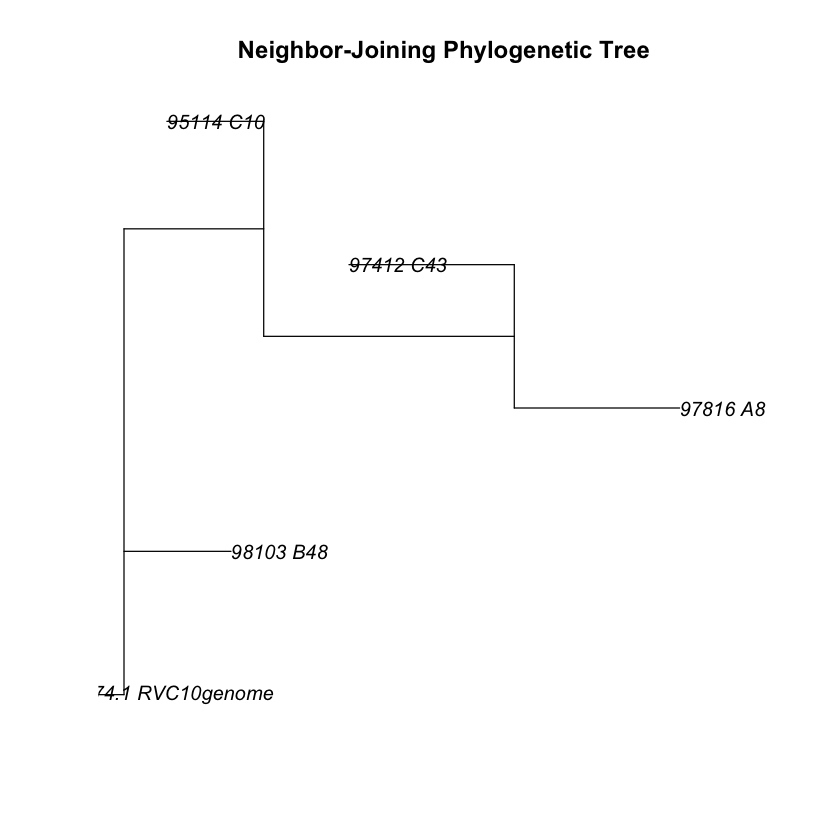

In [173]:
library (ape)
distances <- as.dist(modified_matrix)

# Construct a phylogenetic tree using neighbor-joining method
tree <- nj(distances)

# Plot the phylogenetic tree
plot(tree, main = "Neighbor-Joining Phylogenetic Tree")